## Introduction to ML and OOD 

#### Resources:
   - [Scikit-learn documentation](https://scikit-learn.org/stable/modules/outlier_detection.html) 

#### For the next experiments our OOD class will be for clinical samples from SD-198 and ISIC 2019 will be considered in-distribution

In [26]:
import pandas as pd

groundtruth = pd.read_csv("../data/ISIC2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
indist = list(groundtruth.index)
# oodist = list(groundtruth.index[groundtruth.AK == 1])
# indist = list(groundtruth.index[groundtruth.NV == 1])

#### Now we need to load the images associated to filtered ids
- Resize them to a common shape and return them as numpy arrays
- Associated to the ids for both In-distribution and Out-distribution

In [27]:
import os
from pathlib import Path
import numpy as np
from PIL import Image

X_data = []
ood_data = []

folder_dir = "../data/ISIC2019/ISIC_2019_Training_Input/"
images = Path(folder_dir).glob("*.jpg")

for i in list(images)[:1000]:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    if i.stem in indist:
        X_data.append(img_resize)
        count += 1
    # elif i.stem in oodist:
    #    ood_data.append(img_resize)

In [28]:
ood_dir = "../data/clinical/"
images = Path(ood_dir).glob("*.jpg")
for i in images:
    # image = plt.imread(i)
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_data.append(img_resize)

#### Let see our sample size for both groups with loaded images

In [29]:
len(X_data), len(ood_data)

(1000, 77)

In [30]:
import numpy as np

X_array = np.array(X_data)
ood_array = np.array(ood_data)

In [31]:
y_ind = np.zeros(X_array.shape[0])  # not a OOD sample
y_ood = np.ones(ood_array.shape[0])  # an OOD sample
X = np.concatenate([X_array, ood_array])
y = np.concatenate([y_ind, y_ood])
print(X.shape, y.shape)

(1077, 3072) (1077,)


#### Let's visualize our data with a simple 2 component PCA
- Does this looks like an easy problem? Can you easily separate In-distribution from Out-distribution samples?

explained variance ratio (first two components): [0.49566767 0.13320338]


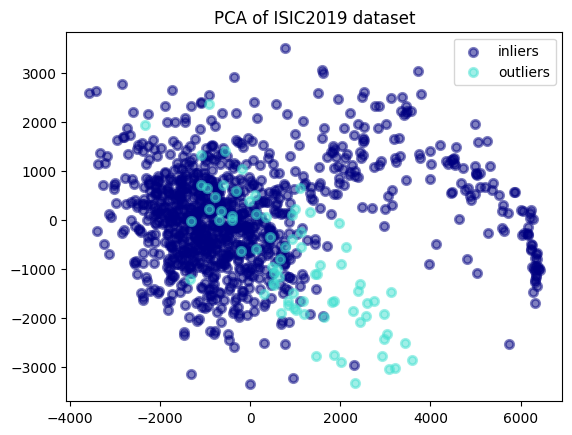

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import aux
import importlib

importlib.reload(aux)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

aux.plot_pca(X_pca, y)

plt.show()

## Isolation Forest

Resources:
- Liu, F.T., Ting, K.M. and Zhou, Z.H., 2012. [Isolation-based anomaly detection](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf). ACM Transactions on Knowledge Discovery from Data (TKDD), 6(1), pp.1-39. 

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, stratify=y, random_state=42
)

clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=200, random_state=0)

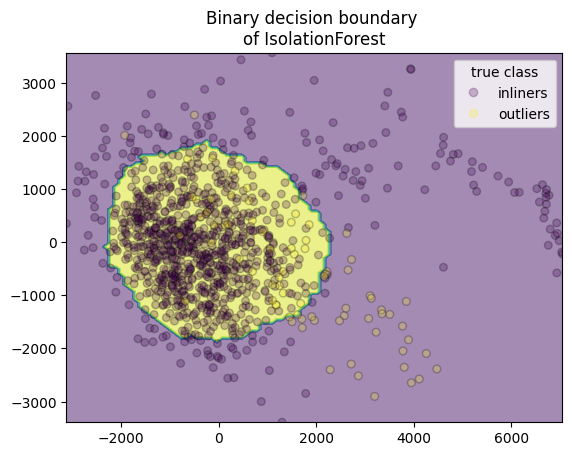

In [15]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_pca,
    response_method="predict",
    alpha=0.5,
)

sc = disp.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30, alpha=0.25, edgecolor="k")
handles, labels = sc.legend_elements()
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.legend(handles=handles, labels=["inliners", "outliers"], title="true class")
plt.show()

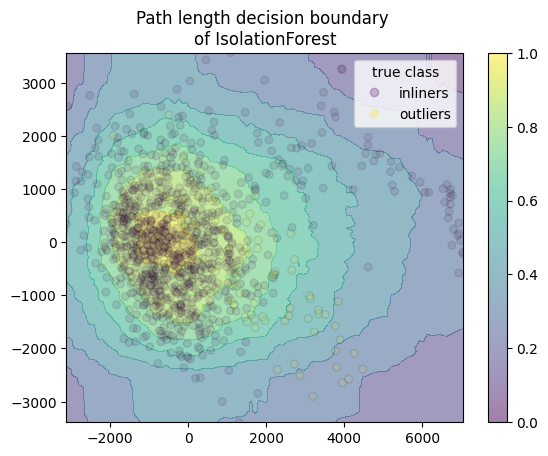

In [16]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_pca,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30, alpha=0.1, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.legend(handles=handles, labels=["inliners", "outliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

### Metrics to assess the outlier detection performance

In [17]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [34]:
from sklearn.metrics import classification_report, roc_curve, auc

fpr, tpr, thresholds_sorted = roc_curve(y_test, clf.predict(X_test))
aucuc = auc(fpr, tpr)
aucuc

0.594988467183896

#### How the raw scores from the Isolation forest look like?

(array([ 4.,  9.,  5., 11., 14., 15., 18., 35., 61., 98.]),
 array([-0.71626199, -0.68331045, -0.65035892, -0.61740738, -0.58445584,
        -0.5515043 , -0.51855276, -0.48560122, -0.45264968, -0.41969815,
        -0.38674661]),
 <BarContainer object of 10 artists>)

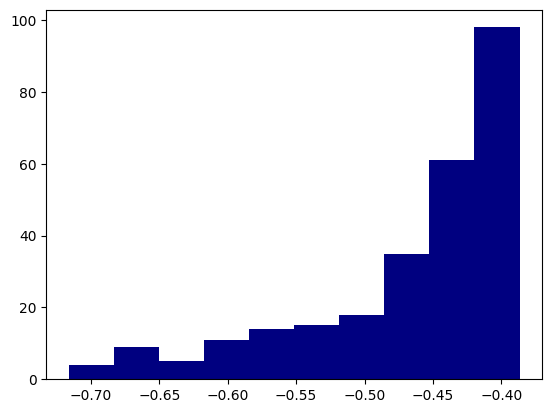

In [35]:
plt.hist(clf.score_samples(X_test), color="Navy")

In [36]:
print(
    classification_report(
        y_test,
        clf.predict(X_test),
        target_names=["Out-distribution", "In-distribution"],
    )
)

                  precision    recall  f1-score   support

Out-distribution       0.12      0.42      0.19        19
 In-distribution       0.95      0.77      0.85       251

        accuracy                           0.74       270
       macro avg       0.53      0.59      0.52       270
    weighted avg       0.89      0.74      0.80       270



### One Class SVM

In [37]:
from sklearn.svm import OneClassSVM

outliers_fraction = 0.15
onesvm = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
onesvm.fit(X_train)

OneClassSVM(gamma=0.1, nu=0.15)

(array([269.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.00241629, 0.00483258, 0.00724887, 0.00966517,
        0.01208146, 0.01449775, 0.01691404, 0.01933033, 0.02174662,
        0.02416291]),
 <BarContainer object of 10 artists>)

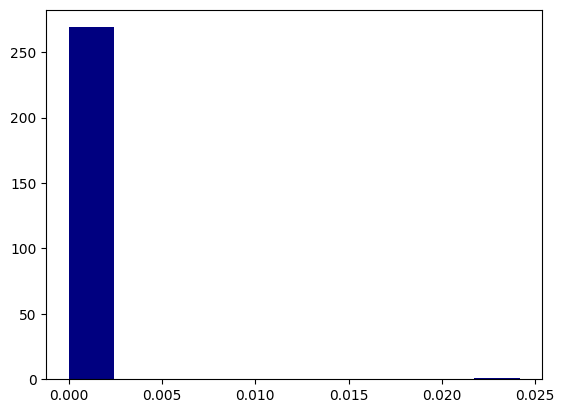

In [38]:
plt.hist(onesvm.score_samples(X_test), color="Navy")

In [39]:
from sklearn import metrics

fpr, tpr, thresholds_sorted = metrics.roc_curve(y_test, onesvm.predict(X_test))
aucuc = metrics.auc(fpr, tpr)
aucuc

0.5

In [40]:
print(
    classification_report(
        y_test,
        onesvm.predict(X_test),
        target_names=["Out-distribution", "In-distribution"],
    )
)

                  precision    recall  f1-score   support

Out-distribution       0.07      1.00      0.13        19
 In-distribution       0.00      0.00      0.00       251

        accuracy                           0.07       270
       macro avg       0.04      0.50      0.07       270
    weighted avg       0.00      0.07      0.01       270



/Users/celiacintas/Code/.venvs/oodhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/celiacintas/Code/.venvs/oodhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/celiacintas/Code/.venvs/oodhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Malaria study 

#### TODO by team

- Prepare numpy arrays with in-distribution and out-distribution labels
- Visualize PCA for all samples
- Run Isolation forest and One-SVM for malaria samples (use grid search to finetune parameters)
- Explore other OOD methods
- View raw anomalous scores for each method and run metrics